# Dependencies

In [ ]:
!pip install einops
!pip install bitsandbytes
!pip install timm flash_attn
!pip install peft
!pip install roboflow
!pip install supervision

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ERROR: Operation cancelled by user
^C


In [1]:
import cv2
import matplotlib.pyplot as plt
import bitsandbytes

In [2]:
pwd

'/home/csegpuserver/Kushagra/Florence_FT_Defence'

In [3]:
cd ..

/home/csegpuserver/Kushagra


# Testing Image Samples

In [38]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 


device = "cuda:1" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("model_checkpoints/epoch_9", torch_dtype=torch.float16, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("model_checkpoints/epoch_9", trust_remote_code=True)



In [12]:
import numpy as np
import supervision as sv

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


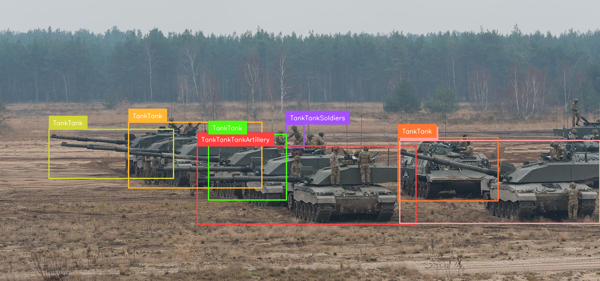

In [39]:
url = "https://imageio.forbes.com/specials-images/imageserve/5ee6b28ac0e4020006640318//0x0.jpg?format=jpg&crop=3000,1407,x0,y451,safe&width=1440"
image = Image.open(requests.get(url, stream=True).raw)
task = "<OD>"
text = "tanks"

inputs = processor(text=text, images=image, return_tensors="pt").to(device)
inputs = {k: v.to(device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device) for k, v in inputs.items()}
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


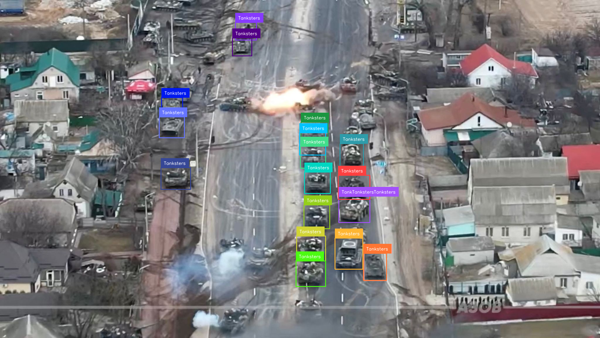

In [40]:
url = "https://e3.365dm.com/22/03/2048x1152/skynews-ukraine-russia_5701297.jpg?20220310134301"
image = Image.open(requests.get(url, stream=True).raw)
task = "<OD>"
text = "tanks"

inputs = processor(text=text, images=image, return_tensors="pt").to(device)
inputs = {k: v.to(device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device) for k, v in inputs.items()}
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


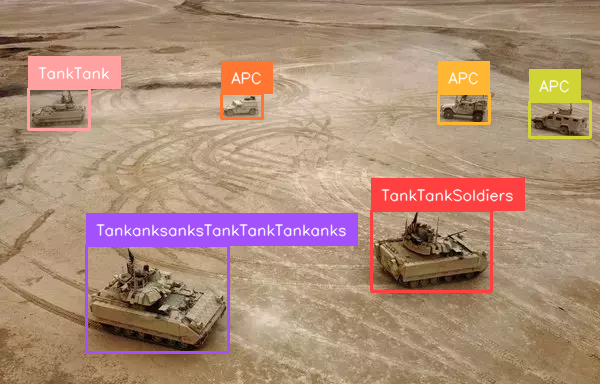

In [41]:
url = "https://centcomcitadel.com/ssc/images/2023/10/04/43984-Bradley-SDF-Syria-600_384.webp"
image = Image.open(requests.get(url, stream=True).raw)
task = "<OD>"
text = "tanks"

inputs = processor(text=text, images=image, return_tensors="pt").to(device)
inputs = {k: v.to(device, dtype=torch.float16) if v.dtype == torch.float32 else v.to(device) for k, v in inputs.items()}
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

# Accuracy Metrics

In [ ]:
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from torchvision.ops import box_iou

# Load model and processor
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("model_checkpoints/epoch_9", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("model_checkpoints/epoch_9", trust_remote_code=True)
# Directory paths
image_dir = "Dataset/Images"
annotations_path = "Dataset/Ff.jsonl" # contains JSNOL files
task = "object-detection"

def decode_annotation(jsnol_text):
    """
    Parses the suffix string into bounding boxes.
    Each <loc_x> in groups of 4 represent [x1, y1, x2, y2].
    """
    import re
    matches = re.findall(r'<loc_(\d+)>', jsnol_text)
    coords = list(map(int, matches))
    return [coords[i:i+4] for i in range(0, len(coords), 4)if i+3 < len(coords)]

# Metrics
total_iou = 0
correct_preds = 0
total_preds = 0
total_gts = 0

with open(annotations_path, 'r') as file:
    lines = file.readlines()

for line in tqdm(lines, desc="Evaluating"):
    jsnol = json.loads(line)
    gt_bboxes = decode_annotation(jsnol['suffix'])
    # print("GT boxes:", gt_bboxes)

    # Load image
    image_path = os.path.join(image_dir, jsnol['image'])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    image = Image.open(image_path).convert("RGB")

    # Prepare input
    inputs = processor(text=jsnol['prefix'], images=image, return_tensors="pt").to(device)
    inputs = {k: v.to(device, dtype=torch_dtype) if v.dtype == torch.float32 else v.to(device) for k, v in inputs.items()}

    # Generate prediction
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
    # print("reponse is :", response)
    pred_string = response.get("object-detection", "")
    pred_bboxes = decode_annotation(pred_string)
    # print("Predicted:", pred_bboxes)

    
    # Format for IoU
    if len(pred_bboxes) == 0 or len(gt_bboxes) == 0:
        continue

    pred_tensor = torch.tensor(pred_bboxes, dtype=torch.float32)
    gt_tensor = torch.tensor(gt_bboxes, dtype=torch.float32)

    ious = box_iou(pred_tensor, gt_tensor)
    max_ious, _ = ious.max(dim=1)

    total_iou += max_ious.sum().item()
    correct_preds += (max_ious > 0.5).sum().item()
    total_preds += len(pred_bboxes)
    total_gts += len(gt_bboxes)

# Final scores
precision = correct_preds / total_preds if total_preds > 0 else 0.0
recall = correct_preds / total_gts if total_gts > 0 else 0.0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
accuracy = correct_preds / (total_preds + total_gts - correct_preds) if (total_preds + total_gts - correct_preds) > 0 else 0.0
avg_iou = total_iou / correct_preds if correct_preds > 0 else 0.0

print("\nEvaluation Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Avg IoU:   {avg_iou:.4f}")

# Refine Best Images

In [ ]:
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from torchvision.ops import box_iou
import shutil

# Load model and processor
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("model_checkpoints/epoch_9", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("model_checkpoints/epoch_9", trust_remote_code=True)

# Directory paths
image_dir = "Dataset/Images"
annotations_path = "Dataset/Ff.jsonl"
output_dir = "RefinedImages"
os.makedirs(output_dir, exist_ok=True)

task = "object-detection"
iou_threshold = 0.7  # Set your preferred threshold

# Metrics
total_iou = 0
correct_preds = 0
total_preds = 0
total_gts = 0
refined_count = 0

def decode_annotation(jsnol_text):
    import re
    matches = re.findall(r'<loc_(\d+)>', jsnol_text)
    coords = list(map(int, matches))
    return [coords[i:i+4] for i in range(0, len(coords), 4) if i+3 < len(coords)]

with open(annotations_path, 'r') as file:
    lines = file.readlines()

for line in tqdm(lines, desc="Evaluating"):
    jsnol = json.loads(line)
    gt_bboxes = decode_annotation(jsnol['suffix'])
    image_path = os.path.join(image_dir, jsnol['image'])

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    image = Image.open(image_path).convert("RGB")

    # Prepare input
    inputs = processor(text=jsnol['prefix'], images=image, return_tensors="pt").to(device)
    inputs = {k: v.to(device, dtype=torch_dtype) if v.dtype == torch.float32 else v.to(device) for k, v in inputs.items()}

    # Generate prediction
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
    pred_string = response.get("object-detection", "")
    pred_bboxes = decode_annotation(pred_string)

    if len(pred_bboxes) == 0 or len(gt_bboxes) == 0:
        continue

    pred_tensor = torch.tensor(pred_bboxes, dtype=torch.float32)
    gt_tensor = torch.tensor(gt_bboxes, dtype=torch.float32)

    ious = box_iou(pred_tensor, gt_tensor)
    max_ious, _ = ious.max(dim=1)

    total_iou += max_ious.sum().item()
    correct_preds += (max_ious > 0.5).sum().item()
    total_preds += len(pred_bboxes)
    total_gts += len(gt_bboxes)

    # === Save image if avg IoU > threshold ===
    avg_iou_image = max_ious.mean().item()
    if avg_iou_image >= iou_threshold:
        shutil.copy(image_path, os.path.join(output_dir, jsnol['image']))
        refined_count += 1

# # Final scores
# precision = correct_preds / total_preds if total_preds > 0 else 0.0
# recall = correct_preds / total_gts if total_gts > 0 else 0.0
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
# accuracy = correct_preds / (total_preds + total_gts - correct_preds) if (total_preds + total_gts - correct_preds) > 0 else 0.0
# avg_iou = total_iou / correct_preds if correct_preds > 0 else 0.0

# print("\nEvaluation Results:")
# print(f"Precision: {precision:.4f}")
# print(f"Recall:    {recall:.4f}")
# print(f"F1 Score:  {f1_score:.4f}")
# print(f"Accuracy:  {accuracy:.4f}")
# print(f"Avg IoU:   {avg_iou:.4f}")
# print(f"Refined images saved: {refined_count}")


# jsonl creation for the refined Images

In [ ]:
import os
import json

# Paths
image_folder = "/path/to/image/folder"
input_jsonl_path = "/path/to/input_annotations.jsonl"
output_jsonl_path = "/path/to/output_filtered_annotations.jsonl"

# Get all image filenames in the folder
image_filenames = set(os.listdir(image_folder))

# Filter and write to new jsonl file
with open(input_jsonl_path, 'r') as infile, open(output_jsonl_path, 'w') as outfile:
    for line in infile:
        try:
            data = json.loads(line)
            if data.get("image") in image_filenames:
                outfile.write(json.dumps(data) + '\n')
        except json.JSONDecodeError:
            continue  # Skip malformed lines

print(f"Filtered annotations saved to: {output_jsonl_path}")
